In [1]:
import scipy
import numpy as np
from scipy.special import roots_legendre, eval_legendre
from numpy.linalg import norm
from scipy import special as ss
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy import *
import pandas as pd

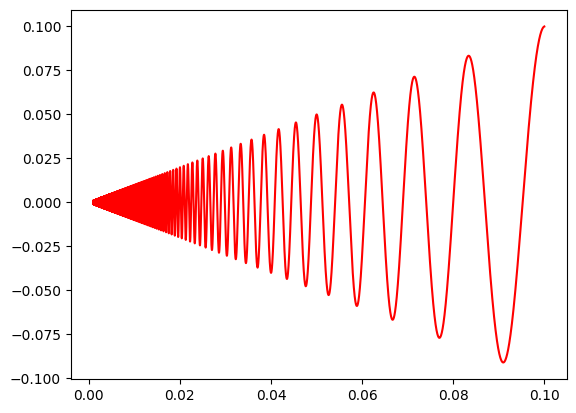

In [16]:
f = lambda x: x*np.cos(np.pi/x)
g = lambda x: f(x)**2

x = np.linspace(.001,.1,1000000)
plt.plot(x,f(x),c='r')

## Stage 1: Construct an initial quadrature on X


In [4]:
## X is the equilateral triangle with vetice (0,0) (1,0) (1/2,sqrt(3)/2)
# a,b = -.5,1
# c,d = -np.sqrt(3)/2,np.sqrt(3)/2

a,b = 0,2
c,d = -1,1
n = 5
from disk_rule import *

w,x,y = disk_rule(10,10,0,0,1)
x+=1
y+=1
# n_w,n_x,n_y = [],[],[]
# for i in range(len(w)):
#     if y[i] > 0:
#         n_w.append(w[i])
#         n_x.append(x[i])
#         n_y.append(y[i])
# w,x,y = n_w,n_x,n_y
NN = (n+1)*(n+2)//2
roots, weights = roots_legendre(2*n)
mapped_roots1 = a + (b-a)*(roots+1)/2
mapped_roots2 = c + (d-c)*(roots+1)/2
mapped_weights1= (b-a)*weights/2
mapped_weights2= (d-c)*weights/2

# tensor_w = mapped_weights1.reshape(n,1)@mapped_weights2.reshape(1,n)

ModuleNotFoundError: No module named 'disk_rule'

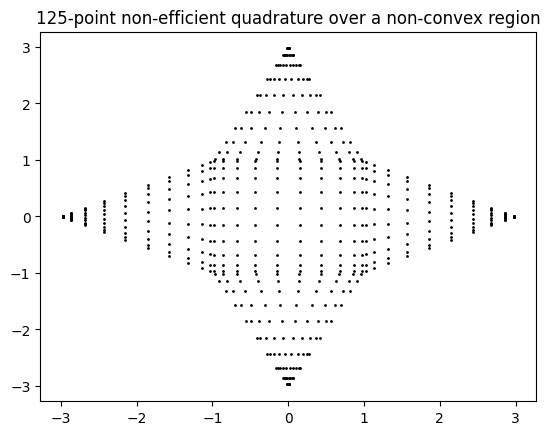

In [ ]:
xx,yy = np.meshgrid(mapped_roots1,mapped_roots2)
plt.title('125-point non-efficient quadrature over a non-convex region')
plt.scatter(yy*(1-xx/2),xx+1,s=1,c='black')
plt.scatter(yy*(1-xx/2),-xx-1,s=1,c='black')
# plt.scatter(xx,yy,s=1,c='black')
plt.scatter(-xx-1,yy*(1-xx/2),s=1,c='black')
plt.scatter(xx-1,yy,s=1,c='black')
plt.scatter(xx+1,yy*(1-xx/2),s=1,c='black')
# plt.savefig('data/initial_nc.png')


# Stage 2: Construct an orthonormal basis of the space $P_n$

In [ ]:
# def int_f(f,n):
#     res = 0
#     for i in range(n):
#         for j in range(n):
#             x,y = mapped_roots1[i] , mapped_roots2[j]
#             res += (2-2*x)/3*tensor_w[i][j] * f(x,(2-2*x)*y/3)
#     return res
    
def int_f(f,n):
    res = 0
    for i in range(len(mapped_roots1)):
        for j in range(len(mapped_roots2)):
            x,y = mapped_roots1[i] , mapped_roots2[j]
            w1,w2 = mapped_weights1[i],mapped_weights2[j]
            res += w1*w2 * f(x, y)
            # res += abs(1-x/2)*w1*w2 * f(x, y*(1-x/2))
            # res += abs(1-x/2)*w1*w2 * f(y*(1-x/2),x+1)
            # res += abs(1-x/2)*w1*w2 * f(-x-1, y*(1-x/2))
            # res += abs(1-x/2)*w1*w2 * f(y*(1-x/2),-x-1)
    return res

# def int_f(f,n):
#     res = 0
#     for i in range(len(mapped_roots1)):
#         for j in range(len(mapped_roots2)):
#             x,y = mapped_roots1[i] , mapped_roots2[j]
#             res += tensor_w[i][j] * f(x, y)
#     return res
# def int_f(f,n):
#     res = 0
#     for i in range(len(w)):
#         res += w[i] * f(x[i],y[i])
#     return np.pi*res
# def int_f(f,n):
#     res = 0
#     for i in range(len(mapped_roots11)):
#         for j in range(len(mapped_roots22)):
#             x1,y1 = mapped_roots1[i] , mapped_roots2[j]
#             x2,y2 = mapped_roots11[i] , mapped_roots22[j]
#             w1,w2 = mapped_weights1[i],mapped_roots2[j]
#             v1,v2 = mapped_weights11[i],mapped_roots22[j]
#             res += w1*w2*f(x1,y1)
#             # res += (1-2*x2/3)*v1*v2*f(x2,x2/np.sqrt(3)+y2-2*x2*y2/3)
#     return res

## Find start and end point of x**i in a 
def start(i,N):
    return (2*N+4-i)*(i-1) // 2
def end(i,N):
    return (2*N+3-i)*i//2-1

def vec2tri(vec,N):
    empty = np.zeros((N+1,N+1))
    for row in range(N):
        s = start(row+1,N)
        e = end(row+1,N)
        new_row = np.concatenate([vec[s:e+1],np.zeros(N-(e-s))],axis=0)
        empty[row] += new_row
    return empty

def tri2vec(tri,N):
    l = []
    for row in range(N+1):
         l.append(tri[row][:N+1-row])
    return np.block(l)

def xvec(vec,k,N):
    vec_tri = vec2tri(vec,N)
    newtri = np.zeros((N+1,N+1))
    for i in range(N):
        for j in range(N):
            if vec_tri[i,j] != 0:
                newtri[i+1,j] = vec_tri[i,j]
    return tri2vec(newtri,N)

def yvec(vec,k,N):
    vec_tri = vec2tri(vec,N)
    newtri = np.zeros((N+1,N+1))
    for i in range(N):
        for j in range(N):
            if vec_tri[i,j] != 0:
                newtri[i,j+1] = vec_tri[i,j]
    return tri2vec(newtri,N)

def eval_vec(vec,x,y,n):
    mat = vec2tri(vec,n)
    res = 0
    for row in range(n):
        for j in range(n):
            res += mat[row][j] * x**row * y**j
    return res

def eval_xderivative(vec,x,y,n):
    mat = vec2tri(vec,n)
    res = 0
    for row in range(n):
        for j in range(n):
            if row == 0:
                res += 0
            else:
                res += row * mat[row][j] * x**(row-1) * y**j
    return res

def eval_yderivative(vec,x,y,n):
    mat = vec2tri(vec,n)
    res = 0
    for row in range(n):
        for j in range(n):
            if j == 0:
                res += 0
            else:
                res += j * mat[row][j] * x**row * y**(j-1)
    return res

def find_basis(d):
    p0 = np.block([1,np.zeros((d+1)*(d+2)//2-1)])
    basis = [p0.reshape(-1,1)]

    for k in range(1,d+1):
        cb = basis.copy()
        for p in basis:
            xb = xvec(p.flatten(),k,d)
            yb = yvec(p.flatten(),k,d)
            cb.append(xb.reshape(-1,1))
            cb.append(yb.reshape(-1,1))
        threeK = np.concatenate(cb,axis=1)    
        u,r,vh = scipy.linalg.svd(threeK)
        basis = []
        for i in range(r.shape[0]):
            basis.append(u[:,i].reshape(-1,1))
    return basis

basis = find_basis(n)


In [ ]:
i,j =2,5
f = lambda m,n:m**i*n**j
int_f(f,n)

15.298901724512774

# Stage 3: Find the eigenvalues of $P_U \circ M_{x+iy}$

In [ ]:
N = len(basis)
A = np.zeros((N,N),dtype=complex)

for i in range(N):
    for j in range(N):
        f = lambda x,y: complex(x,y)*eval_vec(basis[i].flatten(),x,y,n)*np.conj(eval_vec(basis[j].flatten(),x,y,n))
        A[i][j] = int_f(f,n)
eigens = scipy.linalg.eigvals(A)
X,Y = eigens.real,eigens.imag

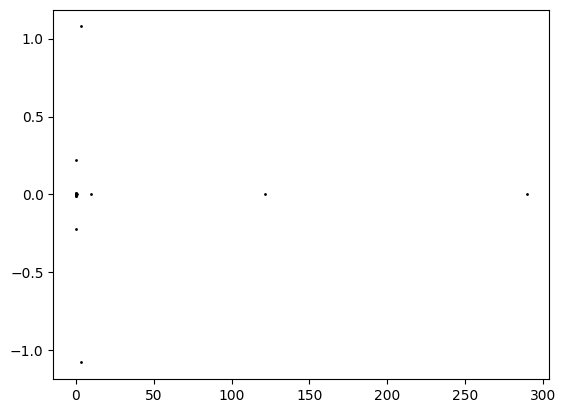

In [ ]:
plt.scatter(X,Y,s=1,c='black')
t = np.linspace(-1,1,100)
# plt.plot(t,(1-t**2)**.5)

# Stage 4: Construct the quadrature

In [32]:
m = 6
M =(m+1)*(m+2)//2
# while M < 3*NN:
#     m += 1
#     M =(m+1)*(m+2)//2
    
basis_m = find_basis(m)
I = []
for j in range(M):
    f = lambda x,y: eval_vec(basis_m[j].flatten(),x,y,m)
    I.append(int_f(f,n))


phi = np.zeros((M,eigens.shape[0]))
for i in range(M):
    p = basis_m[i].flatten()
    for j in range(X.shape[0]):
        # r = mapped_roots[j]
        phi[i][j] = eval_vec(p,X[j],Y[j],m)
# omega,s = scipy.optimize.nnls(phi,np.array(I))
omega = scipy.linalg.lstsq(phi,np.array(I))[0]

In [35]:
x0 = np.concatenate([X,Y,omega])

def F(point):
    x = point[:NN]
    y = point[NN:2*NN]
    w = point[2*NN:]
    res = np.zeros(M)
    for i in range(M):
        eval = np.array([eval_vec(basis_m[i].flatten(),x[j],y[j],m) for j in range(NN)])
        res[i] = eval@w
    res -= I
    return res

def residual(point):
    return (F(point)**2).sum()
def J(point):
    x = point[:NN]
    y = point[NN:2*NN]
    w = point[2*NN:]

    res = np.zeros((M,3*NN))
    for i in range(M):
        dx = np.array([eval_xderivative(basis_m[i].flatten(),x[j],y[j],m) for j in range(NN)])*w
        dy = np.array([eval_yderivative(basis_m[i].flatten(),x[j],y[j],m) for j in range(NN)])*w
        dw = np.array([eval_vec(basis_m[i].flatten(),x[j],y[j],m) for j in range(NN)])
        res[i] = np.concatenate([dx,dy,dw],axis=0)
    return res

def line_search(p,point):
    alpha = 1
    while residual(point+p) > residual(point):
        alpha *=1e-1
        if alpha <= 2e-5:
            break
    # print(alpha,'is selected')
    return alpha




tol = 1e-15
point = x0
step = 0
A = np.eye(3*NN)
mu = 1e-9
for i in range(1000):
    # print(i)
    # step += 1
    # K = J(point).T@J(point)
    # mu = 0.5*scipy.linalg.eigh(K)[-1]
    p = -scipy.linalg.pinv(J(point).T@J(point))@(J(point).T)@F(point)
    
    # p = scipy.linalg.inv(K+mu*A)(J(point).T)@F(point)#+ mu*A
    # alpha = line_search(p,point)
    # print("Linesearch finished")
    alpha = line_search(p,point)
    point_proposal = point + p*alpha
    # diff = (point_proposal - point).reshape(-1,1)

    # A = ((J(point_proposal).T@F(point_proposal)-J(point).T@F(point)).reshape(-1,1)) @ (diff.T) @ scipy.linalg.inv(diff@(diff.T))
    
    if residual(point_proposal) <= tol:
        point = point_proposal
        break
    point = point_proposal
    if i % 10 == 0:
        print(np.linalg.matrix_rank(J(point)))
        print('{}th residual is {}.'.format(i,residual(point)))
    



# from scipy.optimize import root,fsolve,minimize
# # # res,s = minimize(residual,x0).x, minimize(residual,x0)
# # nF = lambda x: F(x)[:3*NN]
# # res = fsolve(nF,x0)
# res = minimize(residual,x0 )
# point,s = res.x,res.success

22
0th residual is 4.38692245114787.
22
10th residual is 4.386922451147721.
22
20th residual is 4.386922451147721.
22
30th residual is 4.386922451147721.
22
40th residual is 4.386922451147721.
22
50th residual is 4.386922451147721.
22
60th residual is 4.386922451147721.
22
70th residual is 4.386922451147721.
22
80th residual is 4.386922451147721.
22
90th residual is 4.386922451147721.
22
100th residual is 4.386922451147721.
22
110th residual is 4.386922451147721.
22
120th residual is 4.386922451147721.
22
130th residual is 4.386922451147721.
22
140th residual is 4.386922451147721.
22
150th residual is 4.386922451147721.


KeyboardInterrupt: 

# 45 Points

In [ ]:
residual(point)


8.844338946022622e-14

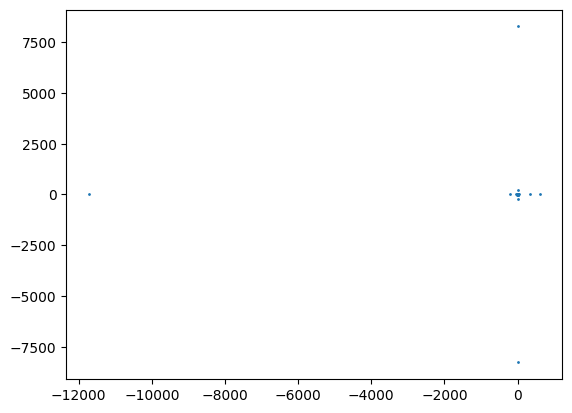

In [ ]:
import matplotlib.pyplot as plt
x = point[:NN]
y = point[NN:2*NN]
w = point[2*NN:]
# for i in range(NN):
#     if abs(x[i]) > 1:
#         x[i] = 
# x[0] = 0
# x[3] = 0
# y[1] = 0
# y[2] = 0
pd.DataFrame(np.array([x, y, w]).T, columns=[
             'x', 'y', 'w']).to_csv('data/sq.csv')
plt.scatter(x, y, s=1)
# plt.xlim(0,1)
# plt.ylim(0,1)
# x1 = np.linspace(0,1/2,100)
# x2 = np.linspace(0.5,1,100)
# y1 = 3**0.5*x1
# y2 = 3**0.5*(1-x2)
# plt.plot(x1,y1)
# plt.plot(x2,y2)
x1 = np.linspace(-1, 1, 1000)

# plt.plot(x1,1-x1)
# plt.plot(x1, (1-x1**2)**0.5)
# plt.plot(x1, -(1-x1**2)**0.5)
# plt.imshow([X,Y],cmap=hot)


In [ ]:
x

array([-1.17197013e+04,  6.47953836e-01,  6.47953836e-01,  6.09182363e+02,
        3.44915693e+02, -2.19131280e+02,  9.58587023e-01,  9.58587023e-01,
       -3.73704528e+01,  1.40153478e+00,  2.89236923e+01,  1.40153478e+00,
        3.51904619e+00,  3.51904619e+00, -2.25553237e+00, -2.25553237e+00,
        2.87772747e-01,  2.87772747e-01,  1.32081262e+00, -5.23969092e-01,
       -5.23969092e-01, -3.35063401e-01,  2.19446131e-01,  2.19446131e-01,
        1.31546541e-01, -1.13137795e-02, -3.19386578e-12,  1.14726623e-12])

In [ ]:
w

array([-1.68247100e-05, -1.57263592e-06, -1.57263592e-06, -2.05515865e-01,
        5.40897377e-01,  2.66239992e-01,  4.33068194e-03,  4.33068147e-03,
        6.17822955e-01, -9.68319541e-02,  6.85497022e-01, -9.68318811e-02,
        6.00455064e-01,  6.00455348e-01,  5.84934245e-01,  5.84934503e-01,
        6.58572459e-01,  6.58571695e-01,  6.61329705e-01,  6.55264248e-01,
        6.55263608e-01,  6.59697421e-01,  6.60183203e-01,  6.60183069e-01,
        6.60159468e-01,  6.60018178e-01,  6.60029373e-01,  6.60029373e-01])

In [ ]:
i,j =4,0
f = lambda x,y:x**i*y**j
res = 0
for k in range(len(w)):
    
    res += w[k]*f(x[k],y[k])
res


-337437183762.0872

In [ ]:
I

[-9.453422794496252e-17,
 -5.187822692048413e-17,
 -2.837318539941243e-17,
 3.9333333333333473,
 -1.427703678750277e-16,
 1.0000000000000016,
 -1.9038590148845458e-16,
 0.0,
 -1.999999999999986,
 0.0,
 -5.880441533018255e-17,
 13.999999999999956,
 13.333333333333304,
 2.0000000000000018,
 11.999999999999973]

In [ ]:
(27/16)**.5